In [1]:
#|default_exp init

In [2]:
import sys
sys.path.insert(1, '/home/umangkaushik/projects/my_fastai_part2')

# Initialization

In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [4]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(69)

In [5]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

bs = 1024
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

  0%|          | 0/2 [00:00<?, ?it/s]

(torch.Size([1024, 1, 28, 28]), tensor([8, 9, 8, 0, 2, 5, 6, 9, 6, 0]))

In [6]:
def get_model():
    return nn.Sequential(
        conv(1, 8),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        nn.Flatten()
    ).to(def_device)

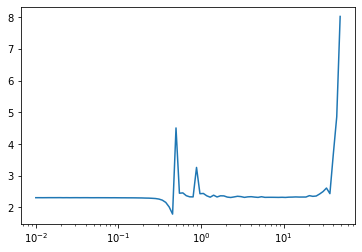

In [7]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [8]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.163,2.278,0,train
0.100,2.351,0,eval


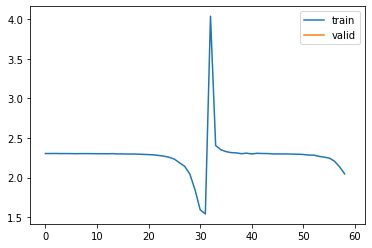

In [9]:
learn.fit(1)

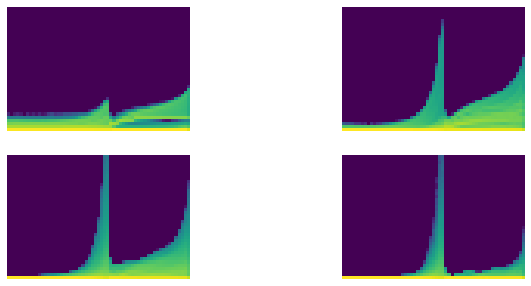

In [10]:
astats.color_dim()

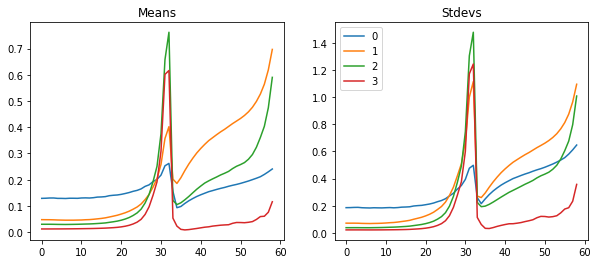

In [11]:
astats.plot_stats()

In [12]:
#|export
def clean_ipython_hist():
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc):
        user_ns.pop('_i' + repr(n), None)
    user_ns.update(dict(_i='', _ii='', _iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc
    hm.input_hist_raw[:] = [''] * pc
    hm._i = hm._ii = hm._iii = hm._i00 = ''

`clean_ipython_hist` is a function for cleaning up the IPython history. It removes the input history from the IPython shell and resets the input prompts.
- The function is `get_ipython` function is available in the global namespace. If it's not found, it means the code is not running in an IPython env., so the function returns immediately without performing any further actions.
- `get_ipython` function is called to retrieve the current IPython instance, which returns the active IPython InteractiveShell object.
- `user_ns` variable is assigned to the user namespace, user namespace is a dictionary that contains all the user-defined variables, functions and imports in the current IPython session.
- `flush` method is called on the IPython display hook (`ip.displayhook`). The display hook is responsible for capturing and displaying the output of the code executed in the IPython shell. Flushing the display hook ensures that any pending output is cleared.
- `prompt_count` variable is assigned the value of the prompt count from the display hook (`ip.displayhook.promt_count`). The prompt count represents the number of input prompts that have been displayed in the IPython shell.
- The code enter a loop, inside the loop the input history variables `_i1` to `_iN` are removes from the user namespace using the `pop` method.
- After the loop, the user namespace is updated using the `update` method. The variables `_i`, `_ii` and `_iii` are set to empty strings, effectively removing their previous values. These variables represent the input history for the current, previous, and pre-previous inputs.
- `hm` variable is assigned to the history manager obtained from the IPython instance (`ip.history_manager`). The history manager is responsible for managing the input and output history in IPython.
- `input_hist_parsed` attribute of the history manager is cleared by setting all the elements to empty strings. This attribute represents the parsed input history, where each element corresponds to the previously executed input.
- `input_hist_raw` attribute of the history manager is cleared by setting all elements to emoty strings. This attribute represents the raw input history, where each element corresponds to the exact text entered by the user.
- Finally, the `_i`, `_ii`, `_iii` and `_i00` in the history manager are set to empty strings. These variables represent the input history for the current, previous, pre-previous and very first inputs.

In [13]:
#|export
def clean_tb():
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value')

`clean_tb` function appears to be a custom function for clearing up the traceback information in Python. It clears the traceback frames and related attributes to remove any references to previous errors or exceptions.
- The function checks if the `sys.last_traceback` attribute exists, which is set by Python when an exception occurs and contains the traceback information.
- If `sys.last_traceback` exists, the `clear_frames` function from the `traceback` module is called passing `sys.last_traceback` as an argument. This funtion clears the traceback frames, effectively removing any references to the traceback information.
- After clearing the frames, the `sys.last_traceback` attribute is deleted using the `delattr` function. This ensures that any remaining references to the previous traceback is removed from the `sys` module.
- The function then checks if `sys.last_type` attrubute exists, which represents the type of the last exception that occured.
- If `sys.last_type` exists, `delattr` is used to delete the attribute, removing any reference to the previous exception type.
- Similarly the function checks if `sys.last_value` exists, which represents the value of the last exception that occured.
- If `sys.last_value` exists, `delattr` is used to delete the attribute, removing any references to the previous exception value.

In [14]:
#|export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## Glorot/Xavier Init

$$ W^{l} := W^{l} . \sqrt{\frac{1}{m^{l-1}}} $$
$$ W^{l} := W^{l} . \frac{1}{\sqrt{n_{in}}} $$

In [15]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [16]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ (torch.randn(100, 100) * 0.01)
x[:5, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [17]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ (torch.randn(100, 100) * 0.1)
x[:5, :5]

tensor([[ 0.62,  1.30,  0.23,  1.15,  1.79],
        [-0.41,  0.35, -0.41,  0.16,  1.27],
        [-0.74, -1.81,  0.70,  0.41,  0.92],
        [-0.27,  0.47,  0.24,  1.51,  1.65],
        [-0.55, -2.98,  1.12, -0.54, -2.55]])

In [18]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.06), tensor(1.10))

In [19]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()
mean/100, sqr/100

(0.005951605215668679, 99.77855476379395)

In [20]:
mean, sqr = 0., 0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a * x
    mean += y.item()
    sqr += y.pow(2).item()
mean/10000, sqr/10000

(-0.006663899448622215, 1.0036935756881502)

## Kaiming/He Init

$$ W^{l} := W^{l} . \sqrt{\frac{2}{n_{in}}}

In [21]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [22]:
from math import sqrt

In [23]:
w1 = torch.randn(100, 50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50, 1) / sqrt(50)
b2  =torch.zeros(1)

In [24]:
def lin(x, w, b): return x @ w + b

In [25]:
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(0.01), tensor(1.02))

In [26]:
def relu(x): return x.clamp_min(0.)

In [27]:
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.41), tensor(0.60))

In [28]:
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ (torch.randn(100, 100) * 0.1))
x[:5, :5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [29]:
x = torch.randn(200, 100)
for i in range(50):
    x = relu(x @ (torch.randn(100, 100) * sqrt(2/100)))
x[:5, :5]

tensor([[0.91, 0.00, 0.23, 1.15, 0.00],
        [0.54, 0.00, 0.21, 0.64, 0.00],
        [0.63, 0.00, 0.27, 0.67, 0.00],
        [0.47, 0.00, 0.10, 0.55, 0.00],
        [0.63, 0.00, 0.18, 0.72, 0.00]])

### Applying a init function

In [30]:
model = get_model()
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [31]:
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [32]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [33]:
model.apply(init_weights);

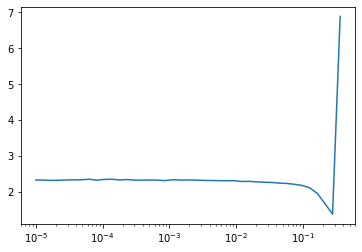

In [34]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

In [35]:
set_seed(69)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, cbs=cbs, lr=0.2)

accuracy,loss,epoch,train
0.555,1.351,0,train
0.737,0.685,0,eval
0.804,0.538,1,train
0.813,0.500,1,eval
0.840,0.442,2,train
0.838,0.444,2,eval


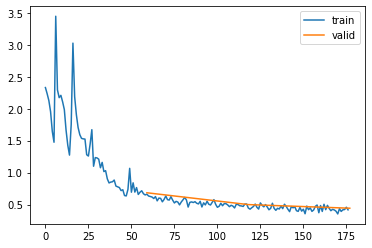

In [36]:
learn.fit(3)

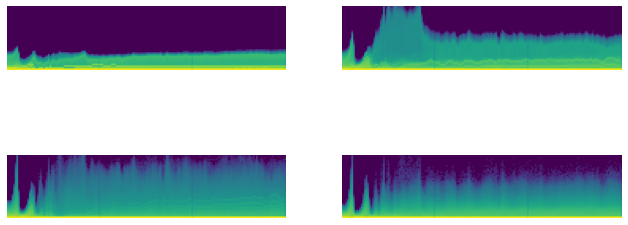

In [37]:
astats.color_dim()

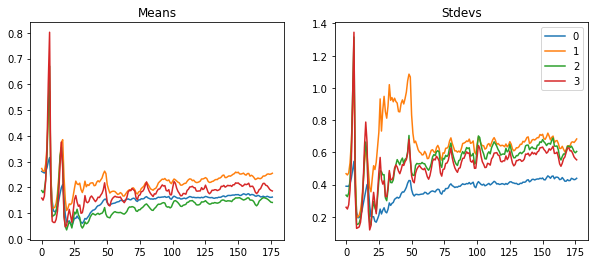

In [38]:
astats.plot_stats()

## Input Normalization

In [39]:
xmean, xstd = x.mean(), x.std()
xmean, xstd

(tensor(0.34), tensor(0.57))

In [40]:
#|export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()
    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [41]:
def _norm(b): return (b[0] - xmean) / xstd, b[1]
norm = BatchTransformCB(_norm)

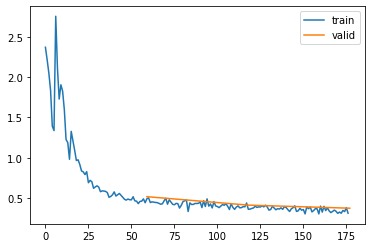

In [42]:
set_seed(69)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs+[norm])
learn.fit(3)

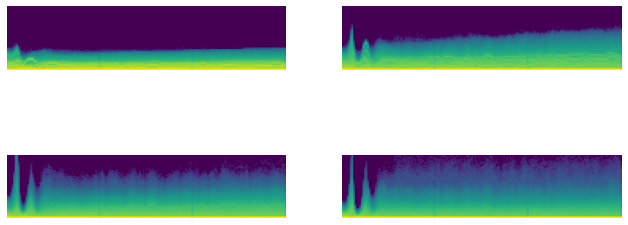

In [43]:
astats.color_dim()

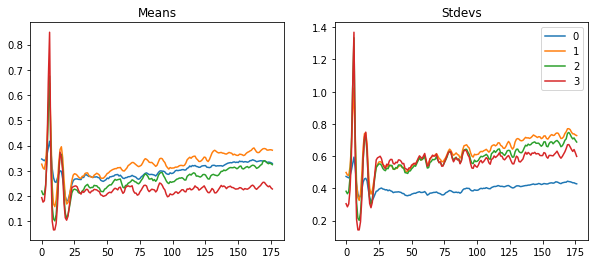

In [44]:
astats.plot_stats()

In [45]:
@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o) - xmean) / xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
xb, yb = next(iter(dls.train))

In [46]:
xb.mean(), xb.std()

(tensor(-0.10), tensor(0.61))

## General ReLU

In [47]:
#|export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x -= self.sub
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [48]:
#|export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

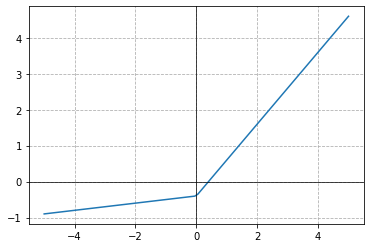

In [49]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [50]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [51]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to(def_device)

In [52]:
#|export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight, a=leaky)

In [53]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [54]:
model = get_model(act_gr).apply(iw)

accuracy,loss,epoch,train
0.763,0.664,0,train
0.839,0.437,0,eval
0.863,0.376,1,train
0.860,0.389,1,eval
0.878,0.335,2,train
0.873,0.350,2,eval


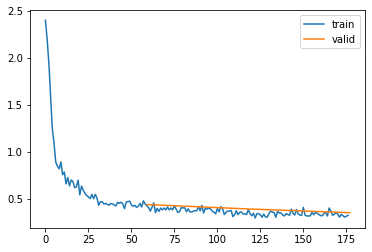

In [55]:
set_seed(69)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

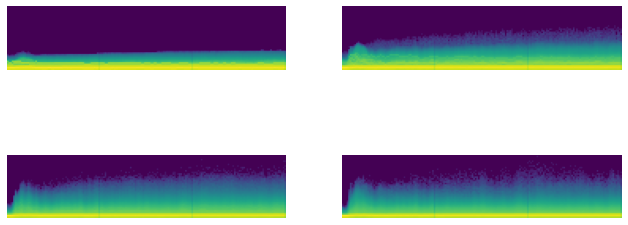

In [56]:
astats.color_dim()

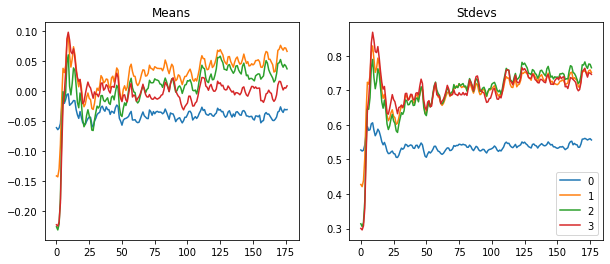

In [57]:
astats.plot_stats()

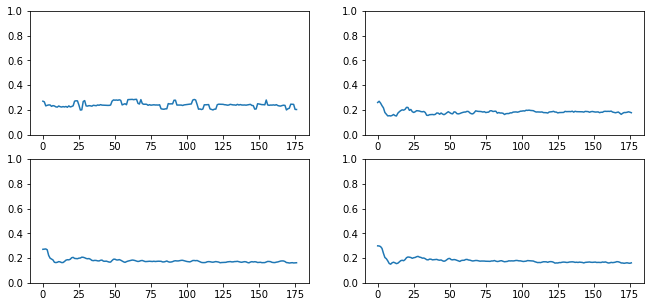

In [58]:
astats.dead_chart()

## LSUV (Layer-wise Sequential Unit-Variance)

- Initialize the weights however you would like.
- Grac a single minibatch. Find all of the modules that are of type conv layer.
- Pass the minibatch through each module and calculate the mean and standard deviation of the activations.
- Create a loop that calls the module passing in the minibatch. Modify the weights iteratively until the mean is close to 0 and standard deviation is close to 1.

In [60]:
#|export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()
    
def lsuv_init(model, m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std - 1) > 1e-3 or abs(h.mean) > 1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

`lsuv_init`
- The function initializes a hook, `h`, on the module `m` to collect the stats during forward passes. The hook is created using the `_lsuv_stats` function.
- The initialization process is performed within a `torch.no_grad()` context, which disables the gradient calculation and updates to the model's parameters.
- While loop is used to iteratively adjust the bias and weight of `m_in` until standard deviation (`h.std`) and mean (`h.mean`) of the activations are close to 1 and 0, respectively.
- In each iteration, the bias of `m_in` is adjusted by subtracting `h.mean`, and the weight of `m_in` is divided by `h.std`.
- The loop continues until the condition is no longer satisfied.
- Finally, the hook `h` is removed.

In [61]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [62]:
for ms in zip(relus, convs): print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [63]:
for ms in zip(relus, convs): lsuv_init(model, *ms, xb.to(def_device))

accuracy,loss,epoch,train
0.772,0.639,0,train
0.833,0.460,0,eval
0.860,0.379,1,train
0.859,0.389,1,eval
0.879,0.331,2,train
0.870,0.362,2,eval


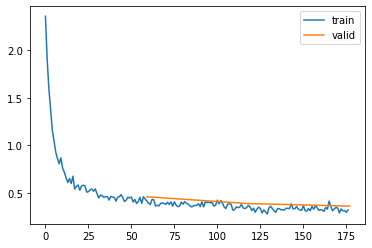

In [64]:
set_seed(69)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

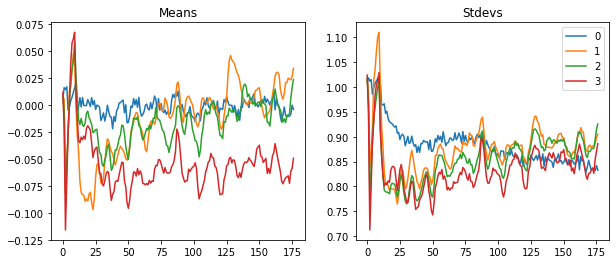

In [65]:
astats.plot_stats()

## BatchNorm

How it works:
1. Normalization
    - activations of each layer are normalized by subtracting the mini-batch mean and dividing by the mini-batch standard deviation.
    - this is done independently for each feature dimension or channel.

    $$ z^{\prime^{[i]}}_j = \frac{z^{[i]}_j - \mu_j}{\sigma_j + \epsilon} $$

2. Learnable Parameters
    - includes a scale parameter (gamma) and a shift parameter (beta).
    - After normalization, the scaled and shifted activations are obtained by multiplying by gamma and adding beta, respectively.

    $$ a^{\prime^{[i]}}_j = \gamma_j . z^{\prime^{[i]}}_j + \beta_j 

3. Mini-Batch Stats
    - it calculates mini-batch mean and standard deviations which are computed using the activations of the current mini-batch.

4. Moving Averages
    - BN maintains exponential moving averages of the mean and standard deviation across multiple mini-batches.
    - These moving averages are used during inference to normalize the activations consistently.

5. Backprop
    - During backprop, gradients are calculated wrt. the normalized inputs.
    - gamma and beta are updated based on these gradients, allowing the network to adapt the normalization process.

### LayerNorm

While BatchNorm normalizes the activations within each mini-batch, LayerNorm normalizes the activations within each individual training sample, typically along a specific feature dimension.

How it works:
1. Normalization:
    - activations of each training sample are normalized by subtracting the mean and dividing by the standard deviation along a specific feature dimension.
    - unlike BN, LN does not use mini-batch stats but computes the stats within each sample independently.
2. Learnable Parameters:
    - LN also introduces learnable parameters to scale and shift the normalized activations, gamma and beta respectively.
    - The scaled and shifted activations are obtained by multiplying activations by gamma and adding beta.
3. Training and Inference:
    - During training, LN computes the mean and standard deviation along the specified feature dimension for each training sample. These stats are used to normalize the activations.
    - During inference, LN uses the learned gamma and beta parameters to normalize the activations. The stats used during training are often discarded and LN operates solely based on the learned parameters.
4. Bakckprop:
    - During backprop, gradients are calculated wrt. the normalized inputs.
    - The gradients are then used to update the learnable parameters (gamma and beta) during the training process.

In [70]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
        
    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True) # calc mean along dimensions 1, 2 and 3
        v = x.var((1, 2, 3), keepdim=True) # calc variance along dimensions 1, 2 and 3
        x = (x - m) / ((v + self.eps).sqrt())
        return x * self.mult + self.add

In [71]:
#|export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None:
        bias = not isinstance(norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [72]:
#|export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1, 8, 16, 32, 64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs) - 1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)

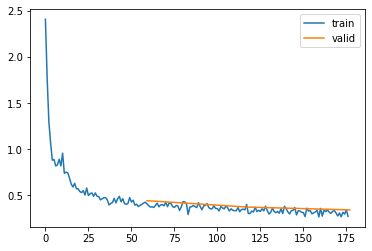

In [73]:
set_seed(69)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

### BatchNorm

In [74]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf, 1, 1))
        self.adds = nn.Parameter(torch.zeros(nf, 1, 1))
        self.register_buffer('vars', torch.ones(1, nf, 1, 1))
        self.register_buffer('means', torch.zeros(1, nf, 1, 1))
        
    def update_stats(self, x):
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v  = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

`torch.lerp(start, end, weight, out=None)`
- performs linear interpolation between 2 tensors.
- commonly used for tasks such as blending between two images or interpolating values in a smooth manner.
- ```output = start + weight * (end - start)```

`register_buffer()`
- typically used to register a buffer that should not be considered a model parameter. Ex, here BN's `means` is not a parameter, but is part of the persistent state.
- model parameters are learned and updated usng SGD during the training process.
- However, sometimes there are quantities that are part of a model's 'state' and should be,
    - saved a part of 'state_dict'
    - moved to 'cuda' or 'cpu' with the rest of the model's parameters
    - cast to 'float/half/double' wth rest of model's parameters
- Registering these 'arguments' as model's 'buffers' allows PyTorch to track them and save them like regular parameters but prevents PyTorch from updating them using SGD mechanism

accuracy,loss,epoch,train
0.787,0.591,0,train
0.783,0.570,0,eval
0.870,0.353,1,train
0.831,0.486,1,eval
0.885,0.312,2,train
0.871,0.353,2,eval


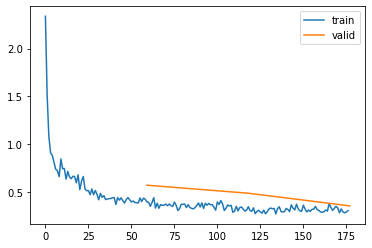

In [75]:
model = get_model(act_gr, norm=BatchNorm).apply(iw)
set_seed(69)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs)
learn.fit(3)

### Towards 90%

In [76]:
dls = DataLoaders.from_dd(tds, 256, num_workers=4)

accuracy,loss,epoch,train
0.839,0.444,0,train
0.873,0.350,0,eval
0.884,0.313,1,train
0.871,0.347,1,eval
0.896,0.281,2,train
0.887,0.305,2,eval


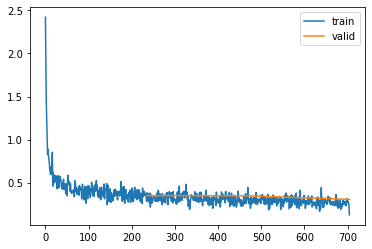

In [77]:
set_seed(69)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(3)

accuracy,loss,epoch,train
0.918,0.223,0,train
0.897,0.278,0,eval
0.922,0.209,1,train
0.900,0.272,1,eval


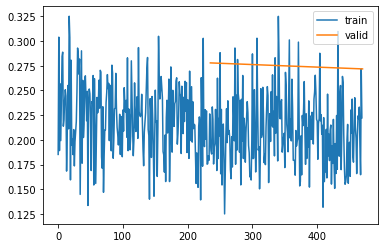

In [78]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)

# Export -

In [81]:
import nbdev
nbdev.nbdev_export()

InterpolationMissingOptionError: Bad value substitution: option 'git_url' in section 'DEFAULT' contains an interpolation key 'user' which is not a valid option name. Raw value: 'https://github.com/%(user)s/%(repo)s'